In [4]:
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mplstereonet
from scipy.stats import wishart

sys.path.append("G:\My Drive\Documents\PhD\Analysis\libs")
import pycompass
from pycompass.SNE import pdf

In [2]:
def vec2TrendPlunge(xyz):
    trend,plunge = np.rad2deg(np.arctan2(xyz[0],xyz[1])), np.rad2deg(-np.arcsin(xyz[2]))
    if (plunge < 0):
        trend,plunge = np.rad2deg(np.arctan2(-xyz[0],-xyz[1])), np.rad2deg(-np.arcsin(-xyz[2]))
    while (trend < 0):
        trend += 360
    return plunge,trend

#function to build eigens from single phi, theta, alpha
def buildEigenvector( phi, theta, alpha ):
    
    #eigen 1 simply in direction defined by trend = phi, plunge = theta
    E1 = np.array( [np.sin(phi) * np.cos(theta),np.cos(phi) * np.cos(theta),-np.sin(theta)] ).T
    
    #special case breaks rotation maths
    if (E1 == np.array([0,0,1])).all():
        E1 = [0,1e-6,0.999999] / np.linalg.norm([0,1e-6,0.999999]) #fudge so it is slightly off
        print ('Warning: E1 cannot equal 0,0,1 - adding small fudge factor.')
        
    #eigen 2 is defined by angle alpha in the plane perpendicular to E1
    #E2 = np.cos(alpha) * E1 + np.sin(alpha) * np.cross( np.array([0,0,1]), E1 )
    E2 = np.array( [ np.sin(phi) * np.sin(theta) * np.sin(alpha) - np.cos(phi) * np.cos(alpha),
                     np.sin(phi) * np.cos(alpha) + np.sin(theta) * np.cos(phi) * np.sin(alpha),
                     np.sin(alpha) * np.cos(theta) ]).T
    
    #E3 = E1 x E2
    #E3 = np.cross(E1,E2)
    E3 = np.array([ np.sin( theta) * np.sin(phi) * np.cos(alpha) + np.cos(phi) * np.sin(alpha),
                    np.sin(theta) * np.cos(phi) * np.cos(alpha) - np.sin(phi) * np.sin(alpha),
                    np.cos(theta) * np.cos(alpha) ]).T
    
    #print trend and plunge of E1 (this should equal theta->phi)
    return E1, E2, E3

"""
Build a synthetic covariance matrix in which:
  eig1 = 1, with corresponding vector pointing in the direction (phi,theta)
  eig2 = eig2, with vector perpendicular to (phi,theta) and rotated by angle alpha
  eig3 = eig3, withe vector perpendicular to eig1 and eig2.
"""
def buildP( phi, theta, alpha, eig2, eig3):
    #build eigenvector matrix
    E1,E2,E3 = buildEigenvector(phi,theta,alpha)
    basis = np.vstack( [E1,E2,E3] ).T #build list of basis matrices (basis[i] = matrix who's columns are the i'th E1,E2,E3)
    
    #build eigenvalue matrix
    eigM = np.array( [[1,0,0],[0,eig2,0],[0,0,eig3]])
    
    #calculate inverse of basis matrix
    invB = basis.T #np.linalg.inv(basis)

    #return a set of P-matrices by calculating B.E.Bt where B is each basis matrix, E is each eigenvalue matrix and Bt is each
    #inverse (transposed) basis.
    return np.dot(basis,np.matmul(eigM,invB))
    #return np.einsum('xij,xjk->xik', basis, np.einsum('xij,xjk->xik', eigM, invB))

In [3]:
class MCMC:
    def __init__(self,phi,theta,alpha,e2,e3,data,n):
        #set initial position
        self.phi = phi
        self.theta = theta
        self.alpha = alpha
        self.e2 = e2
        self.e3 = e3
        self.data = data
        self.n = n
        self.ll = None #used to store log-likelihood
        self.timeout = int(1e6) #timeout after 1 million iterations
    def propose(self):
        phi = self.phi +  np.deg2rad(np.random.normal(0,5))
        theta = self.theta + np.deg2rad(np.random.normal(0,5))
        alpha = self.alpha + np.deg2rad(np.random.normal(0,5))
        e2 = self.e2 + np.random.normal(0,0.1)
        e3 = self.e3 + np.random.normal(0,0.1)
        
        #map phi/theta/alpha to 0 <- angle <- 360 degrees
        angles = [phi,theta,alpha]
        for i,a in enumerate(angles):
            while angles[i] < 0:
                angles[i] += 2*np.pi
            while angles[i] > 2 * np.pi:
                angles[i] -= 2 * np.pi
        phi,theta,alpha = angles
        
        if theta > np.pi/2: #ensure dip is < 90 degrees
            theta = np.pi - theta
            phi += np.pi
            if phi > 2 * np.pi:
                phi -= 2 * np.pi #ensure we haven't flipped out
        
        return MCMC(phi,theta,alpha,e2,e3,data=self.data,n=self.n)
    
    def lik(self):
        if self.ll != None:
            return self.ll #likelihood aready computed
        
        ############################################
        #evaluate the likelihood of this position
        ############################################

        #check that 0 < e3 < e2 < 1 and alpha < 180
        if self.e3 < 0 or self.e2 < self.e3 or self.e2 > 1 or self.alpha > np.pi:
            return -1.79769313485e+308 #force sampler away from here
        
        #generate P matrix
        P = buildP(self.phi,self.theta,self.alpha,self.e2,self.e3)
        
        #sample likelihood from wishart distribution
        self.ll = np.log( wishart.pdf( self.data*self.n, df=self.n+1, scale=P ) )
        
        #todo - incorporate prior
        #self.ll += self.prior()
        
        return self.ll
    
    def jump(self):
        i = 0
        while i < self.timeout:
            #generate a proposal
            proposal = self.propose()

            #evaluate proposed likelihood
            p_accept = proposal.lik() - self.lik()

            if np.log(np.random.rand()) < p_accept: #sample value between 0 - 1. If less than p_accept then we accept this
                return proposal #accept and return
            
            i+=1 #try again :(
        assert False, "Error - mcmc sampler exceded max iterations (%d) without accepting a sample." % self.timeout
    
#generate a mcmc trace
def trace(initial,n=1000,):
    out = []
    pos = initial
    for i in range(n):
        pos = pos.jump()
        out.append(pos)
    return out

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log


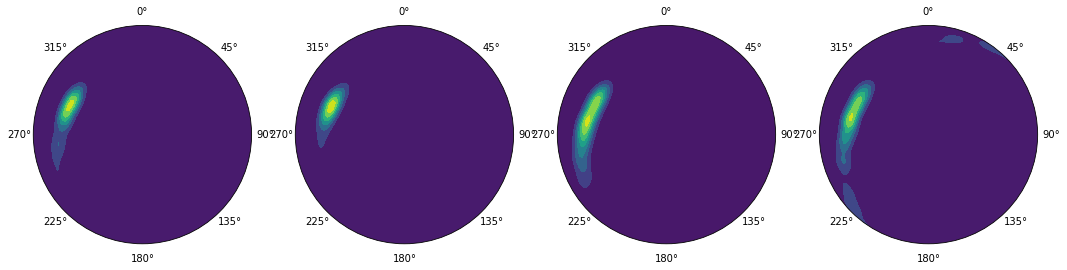

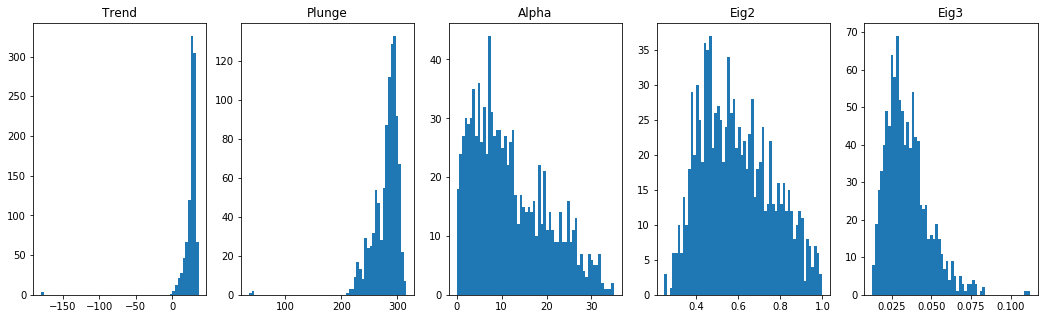

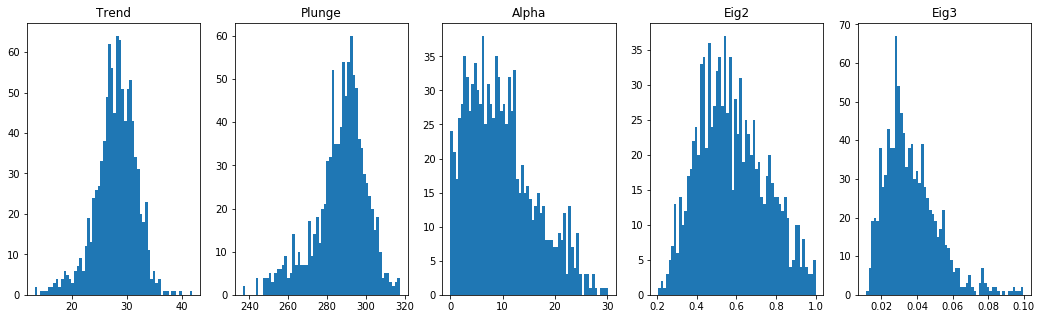

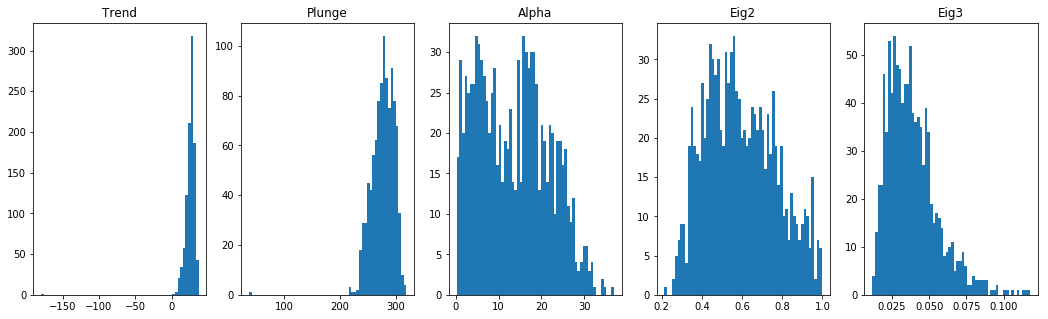

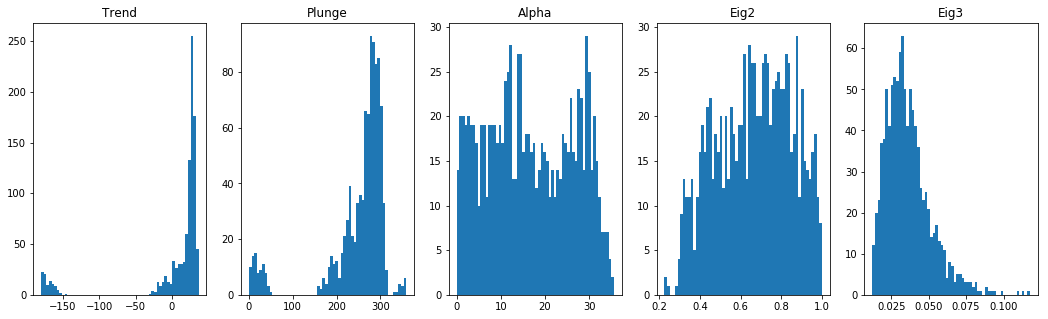

In [4]:
#################################################
#TEST 1 - CHECK FOR CONVERGENCE AND CONSISTENCY
#################################################

#define P-matrix
phi = np.deg2rad(305)
theta = np.deg2rad(30)
alpha = np.deg2rad(0)
e2 = 0.45
e3 = 0.025
n = 25
P = buildP(phi,theta,alpha,e2,e3) #build

#do sampling
trials=4
fig, ax = mplstereonet.subplots(1,trials,figsize=(18,6))
recompute=True
if recompute:
    samples = []
for i in range(trials):
    if recompute:
        samples.append(trace(MCMC(phi,theta,alpha,e2,e3,data=P,n=n),n=1000))

#plot steonets
for i in range(trials):
    trend = []
    plunge = []
    for s in samples[i]:
        trend.append(np.rad2deg(s.theta))
        plunge.append(np.rad2deg(s.phi))
        
    #plot stereonet
    cax = ax[i].density_contourf(trend, plunge, measurement='lines')
plt.show()

#plot histograms
for i in range(trials):
    #gather data
    trend = []
    plunge = []
    _a = []
    _e2 = []
    _e3 = []
    for s in samples[i]:
        trend.append(np.rad2deg(s.theta))
        plunge.append(np.rad2deg(s.phi))
        _a.append(np.rad2deg(s.alpha))
        _e2.append(s.e2)
        _e3.append(s.e3)
        
    #plot histogram
    titles=["Trend","Plunge","Alpha","Eig2","Eig3"]
    fig2,ax2=plt.subplots(1,5,figsize=(18,5))
    for i,d in enumerate([trend,plunge,_a,_e2,_e3]):
        ax2[i].hist(d,bins=60)
        ax2[i].set_title(titles[i])
        
#fig.colorbar(cax)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log


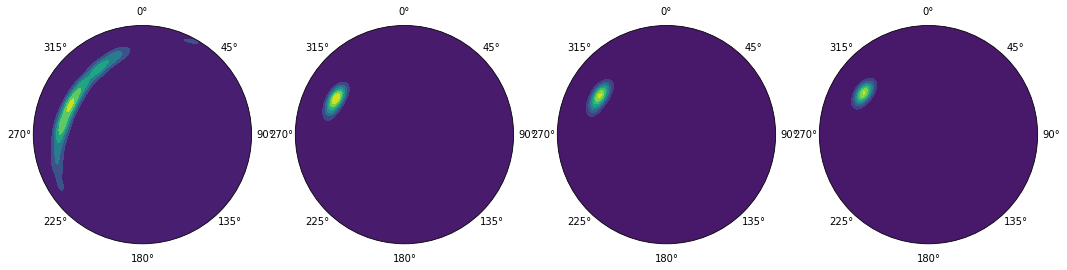

In [5]:
##########################################################
#TEST 2 - REPRODUCE KNOWN P MATRICES FROM PLANARITY VALUES
#########################################################
phi = np.deg2rad(305)
theta = np.deg2rad(30)
alpha = np.deg2rad(0)

p = [0.5,0.75,0.8,0.9] #planarity value
e = [0.005]#,0.1,0.15] #eig3 value - these tend to be really small as the trace is long
n = 25

for _e in e:
    out = []
    titles=[]
    fig, ax = mplstereonet.subplots(1,len(p),figsize=(18,6))
    for i,_p in enumerate(p):
        #calculate e2 from planarity
        e2 = 1 - _p
        
        #build P-matrix with this planarity value
        P = buildP(phi,theta,alpha,e2,_e)
        
        #sample
        samples = trace(MCMC(phi,theta,alpha,e2,e3,data=P,n=n),n=1000)
        trend = []
        plunge = []
        for s in samples:
            trend.append(np.rad2deg(s.theta))
            plunge.append(np.rad2deg(s.phi))
            
        #plot
        #titles.append("planarity = %.2f (e2 = %.2f, e3=%f)" % (_p,e2,_e))
        cax = ax[i].density_contourf(trend, plunge, measurement='lines')
    plt.show()

### Test MCMC cython code

-  This should reproduce the above plots

Sampled 5000 points in 78614 iterations. On average 15.0 iterations were needed per sample.
Sampled 5000 points in 79769 iterations. On average 15.0 iterations were needed per sample.
Sampled 5000 points in 77559 iterations. On average 15.0 iterations were needed per sample.
Sampled 5000 points in 72882 iterations. On average 14.0 iterations were needed per sample.


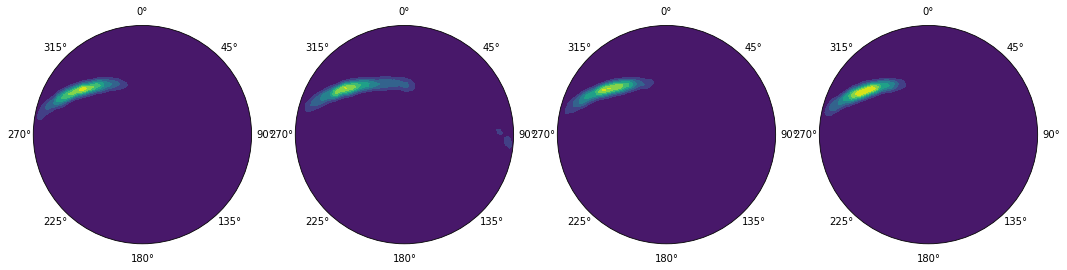

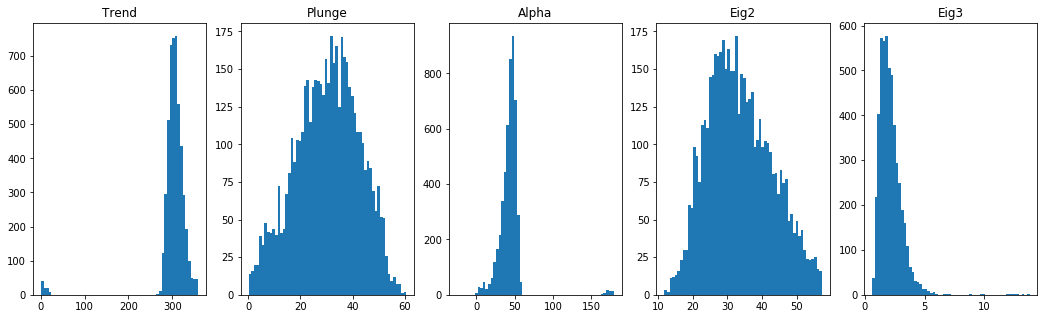

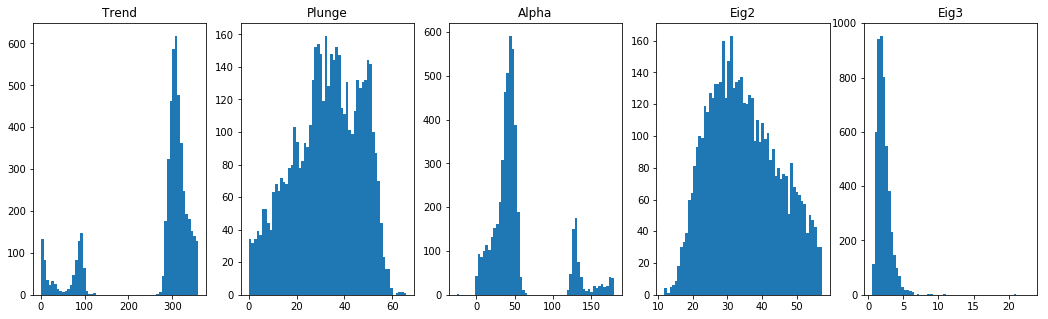

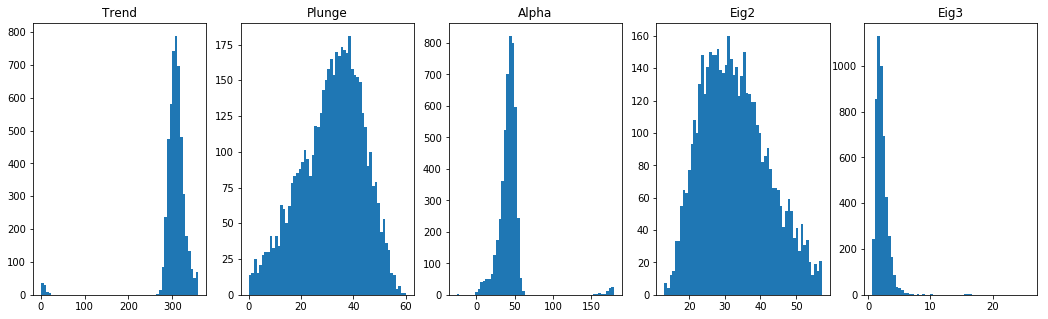

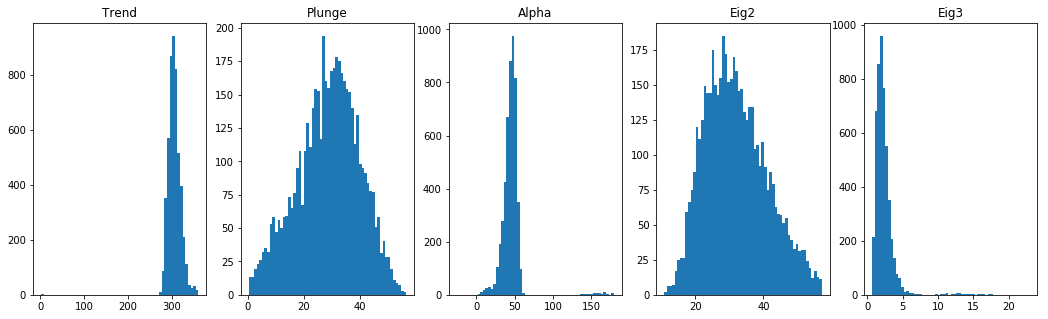

In [7]:
#################################################
#TEST 1 - CHECK FOR CONVERGENCE AND CONSISTENCY
#################################################

#define P-matrix
phi = np.deg2rad(305)
theta = np.deg2rad(30)
alpha = np.deg2rad(45)
e2 = 0.45
e3 = 0.025
n = 25
P = pdf.constructP(phi,theta,alpha,e2,e3) #build

#do sampling
trials=4
fig, ax = mplstereonet.subplots(1,trials,figsize=(18,6))
samples = []
for i in range(trials):
    #sample
    samples.append(pdf.samplePosteriorMCMC(P,n,None,5000))
    

#plot steonets
for i in range(trials):
    plunge = np.rad2deg(samples[i][:,1])
    bearing = np.rad2deg(samples[i][:,0])
        
    #plot stereonet
    cax = ax[i].density_contourf(plunge, bearing, measurement='lines')
plt.show()

#plot histograms
for i in range(trials):
    #gather data
    trend = np.rad2deg(samples[i][:,0])
    plunge = np.rad2deg(samples[i][:,1])
    _a = np.rad2deg(samples[i][:,2])
    _e2 = np.rad2deg(samples[i][:,3])
    _e3 =  np.rad2deg(samples[i][:,4])
        
    #plot histogram
    titles=["Trend","Plunge","Alpha","Eig2","Eig3"]
    fig2,ax2=plt.subplots(1,5,figsize=(18,5))
    for i,d in enumerate([trend,plunge,_a,_e2,_e3]):
        ax2[i].hist(d,bins=60)
        ax2[i].set_title(titles[i])
        
#fig.colorbar(cax)
plt.show()

Sampled 2000 points in 439220 iterations. On average 219.0 iterations were needed per sample.
Sampled 2000 points in 377783 iterations. On average 188.0 iterations were needed per sample.
Sampled 2000 points in 386513 iterations. On average 193.0 iterations were needed per sample.
Sampled 2000 points in 435692 iterations. On average 217.0 iterations were needed per sample.


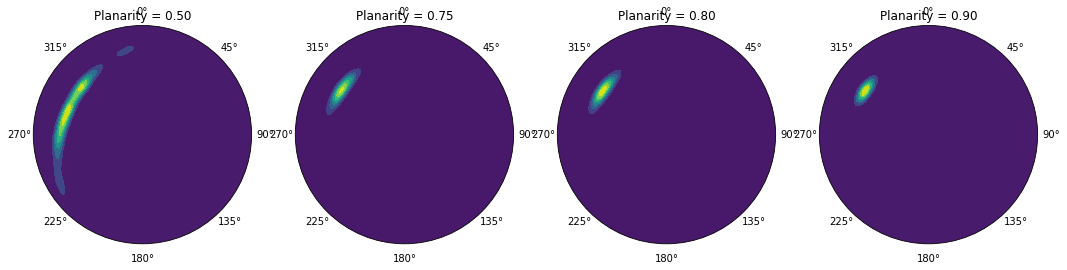

In [8]:
##########################################################
#TEST 2 - REPRODUCE KNOWN P MATRICES FROM PLANARITY VALUES
#########################################################
phi = np.deg2rad(305)
theta = np.deg2rad(30)
alpha = np.deg2rad(0)

p = [0.5,0.75,0.8,0.9] #planarity value
e = [0.005]#,0.1,0.15] #eig3 value - these tend to be really small as the trace is long
n = 25

for _e in e:
    out = []
    titles=[]
    fig, ax = mplstereonet.subplots(1,len(p),figsize=(18,6))
    for i,_p in enumerate(p):
        #calculate e2 from planarity
        e2 = 1 - _p
        
        #build P-matrix with this planarity value
        P = pdf.constructP(phi,theta,alpha,e2,_e)
        
        #sample
        samples = pdf.samplePosteriorMCMC(P,n,None,2000)
        bearing = np.rad2deg(samples[:,0])
        plunge = np.rad2deg(samples[:,1])
            
        #plot
        #titles.append("planarity = %.2f (e2 = %.2f, e3=%f)" % (_p,e2,_e))
        cax = ax[i].density_contourf(plunge, bearing, measurement='lines')
        ax[i].set_title("Planarity = %.2f" % _p)
    plt.show()

Sampled 1000 points in 15786 iterations. On average 15.0 iterations were needed per sample.
Sampled 1000 points in 131332 iterations. On average 131.0 iterations were needed per sample.
Sampled 1000 points in 600206 iterations. On average 600.0 iterations were needed per sample.
Sampled 1000 points in 2047015 iterations. On average 2047.0 iterations were needed per sample.


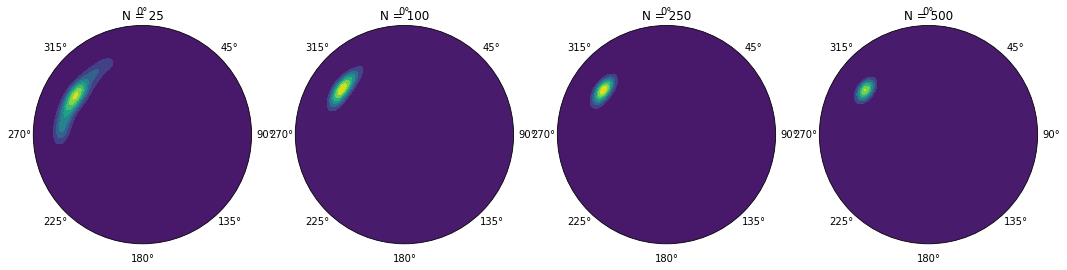

In [9]:
############################################
#TEST 3 - EXPLORE EFFECT OF CHANGING N
############################################
phi = np.deg2rad(305)
theta = np.deg2rad(30)
alpha = np.deg2rad(0)
e2 = 0.45
e3 = 0.025
P = pdf.constructP(phi,theta,alpha,e2,e3) #build

fig, ax = mplstereonet.subplots(1,4,figsize=(18,6))
for i,n in enumerate([25,100,250,500]):
    S = pdf.samplePosteriorMCMC(P,n,None,1000)
    
    plunge = np.rad2deg(S[:,1])
    bearing = np.rad2deg(S[:,0])
    cbar = ax[i].density_contourf(plunge, bearing, measurement='lines')
    ax[i].set_title("N = %d" % n)
plt.show()

In [10]:
phi = np.deg2rad(305)
theta = np.deg2rad(30)
alpha = np.deg2rad(0)
e2 = 0.45
e3 = 0.025
P = pdf.constructP(phi,theta,alpha,e2,e3) #build

for i,n in enumerate([25,100,200,300]):
    print ("N = %d" % n)
    %timeit pdf.samplePosteriorMCMC(P,n,None,2000,verbose=False)

N = 25
44.3 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
N = 100
147 ms ± 4.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
N = 200
401 ms ± 32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
N = 300
811 ms ± 56.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Proposal-width = 0.010
32 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Sampled 2000 points in 3689 iterations. On average 1.0 iterations were needed per sample.
Proposal-width = 0.025
35.4 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Sampled 2000 points in 10020 iterations. On average 5.0 iterations were needed per sample.
Proposal-width = 0.050
47.4 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Sampled 2000 points in 31849 iterations. On average 15.0 iterations were needed per sample.
Proposal-width = 0.100
117 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Sampled 2000 points in 200477 iterations. On average 100.0 iterations were needed per sample.


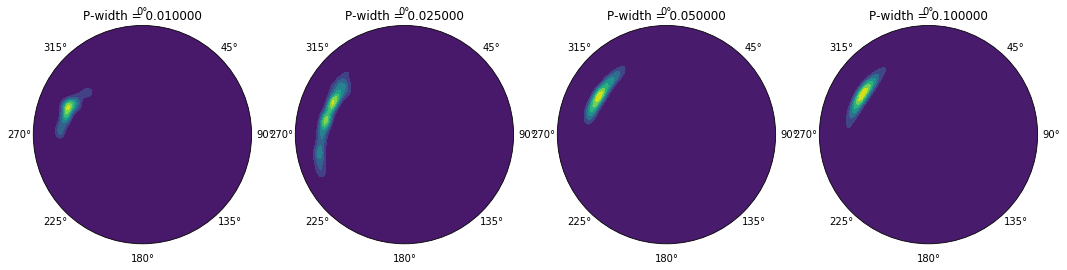

In [11]:
###################################################################
#LOOK AT EFFECT OF PROPOSAL WIDTH ON SAMPLING TIME AND RESULTS
###################################################################
fig, ax = mplstereonet.subplots(1,4,figsize=(18,6))
for i,pwidth in enumerate([0.01,0.025,0.05,0.1]):
    print ("Proposal-width = %.3f" % pwidth)
    %timeit pdf.samplePosteriorMCMC(P,50,None,2000,proposalWidth=pwidth,verbose=False)
    
    S = pdf.samplePosteriorMCMC(P,50,None,2000,proposalWidth=pwidth)
    
    plunge = np.rad2deg(S[:,1])
    bearing = np.rad2deg(S[:,0])
    cbar = ax[i].density_contourf(plunge, bearing, measurement='lines')
    ax[i].set_title("P-width = %f" % pwidth)
plt.show()

### Test grid function

In [4]:
#utitlity function for plotting grids
def plotGrids(titles, grid, values):
    """
    Plots a list of values on a gridded stereonets. The grid is 
    is expected to be a complete hemisphere in lat/long coordinates.
    """
        
    nAxes = len(values) #number of axes to draw
    bound = np.pi / 2 #boundaries of the stereonet hemisphere
    minV = 99999999999999999 #min for color ramp
    maxV = -9999999999999999 #max for color ramp
    
    patches = [] #list of patch objects for each grid
    for i in range(len(values)):
        
        #build patches for this grid
        patches.append([])
        
        #loop through points in grid and create patch objects
        for _lat,_lon in grid.T:
            patches[i].append(mpl.patches.Circle( (_lon, _lat), .02)) #store "dot" for plotting
        
        #check minV and maxV
        if np.min(values[i]) < minV:
            minV = np.min(values[i])
        if np.max(values[i]) > maxV:
            maxV = np.max(values[i])
    
    #init figure
    fig = plt.figure(figsize=(5 * nAxes, 5))
    
    #build throw-away axes to get color-ramp object
    cmap_name = "viridis" #plasma
    ax = fig.add_subplot(111, projection='stereonet')
    x = np.linspace(minV,maxV)
    y = np.linspace(minV,maxV)
    CS3 = ax.scatter(x,y,c=x, cmap=cmap_name)
    fig.clf()
    
    #create normalization object for color-mapping
    #now create colour map
    cmap = mpl.cm.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=minV,vmax=maxV) 

    #build axes
    for i in range(nAxes):
        pos = "1%d%d" % (nAxes,i+1)
        ax = fig.add_subplot(pos, projection='stereonet')
        ax.set_title(titles[i],y=1.08)
        
        #reshape grid for matplotlib contourf
        res = int(np.sqrt(len(values[i])))
        assert res**2 == len(values[i]), "Error: values must be sampled from a square grid."
        vals = np.reshape(values[i],(res,res)).T
        
        
        #push contour points
        bound = np.pi / 2
        ax.contourf(np.linspace(-bound,bound,res),np.linspace(-bound,bound,res), vals)
        
        #ax.set_facecolor(cmap(0)) #set background color
        
        #calculate patch colors
        #rgba = cmap( norm( values[i] ) )  
        
        #gather and plot patches
        #collection = mpl.collections.PatchCollection(patches[i])
        #collection.set_facecolor(rgba)
        #collection.set_edgecolor(rgba)
        #ax.add_collection(collection)
        #ax.grid(color='w', linestyle='--', linewidth=0.75)
        
    #finally, add the color-ramp
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
    fig.colorbar(CS3, cax=cbar_ax)
    
    return fig
def vec2TrendPlunge(xyz):
    trend,plunge = np.rad2deg(np.arctan2(xyz[0],xyz[1])), np.rad2deg(-np.arcsin(xyz[2]))
    if (plunge < 0):
        trend,plunge = np.rad2deg(np.arctan2(-xyz[0],-xyz[1])), np.rad2deg(-np.arcsin(-xyz[2]))
    while (trend < 0):
        trend += 360
    return plunge,trend

In [13]:
#################################################
#TEST 1 - CHECK FOR CONVERGENCE AND CONSISTENCY
#################################################
phi = np.deg2rad(305)
theta = np.deg2rad(30)
alpha = np.deg2rad(45)
e2 = 0.45
e3 = 0.025
n = 25
P = pdf.constructP(phi,theta,alpha,e2,e3) #build

grid = pdf.grid(50)

#force sampler away from least squares best-fit plane
normal = pdf.trendPlunge2Vec(phi,theta)

#do sampling
trials=4
out = []
for i in range(trials):
    #sample
    out.append(pdf.gridPosteriorMCMC(grid, pdf.samplePosteriorMCMC(P,n,normal,5000)))

Sampled 5000 points in 81286 iterations. On average 16.0 iterations were needed per sample.
Sampled 5000 points in 80831 iterations. On average 16.0 iterations were needed per sample.
Sampled 5000 points in 81649 iterations. On average 16.0 iterations were needed per sample.
Sampled 5000 points in 75946 iterations. On average 15.0 iterations were needed per sample.


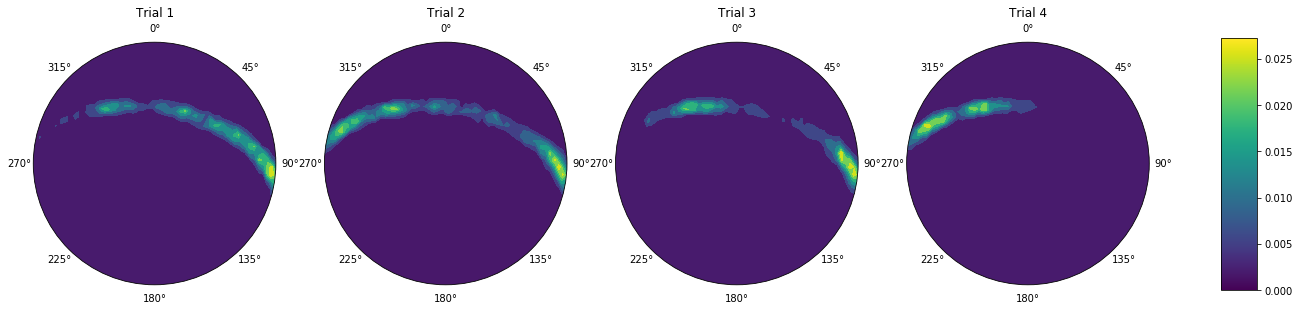

In [14]:
#plot steonets
plotGrids(["Trial 1","Trial 2","Trial 3","Trial 4"],grid,out)
plt.show()

In [15]:
##############################
#Changing N
##############################

phi = np.deg2rad(305)
theta = np.deg2rad(30)
alpha = np.deg2rad(0)
e2 = 0.45
e3 = 0.025
P = pdf.constructP(phi,theta,alpha,e2,e3) #build

grid = pdf.grid(75)

out = []
titles = []
for i,n in enumerate([25,100,250,500]):
    out.append(pdf.gridPosteriorMCMC(grid, pdf.samplePosteriorMCMC(P,n,None,5000)))
    titles.append("N = %d" % n)

Sampled 5000 points in 75895 iterations. On average 15.0 iterations were needed per sample.
Sampled 5000 points in 615002 iterations. On average 123.0 iterations were needed per sample.
Sampled 5000 points in 3058572 iterations. On average 611.0 iterations were needed per sample.
Sampled 5000 points in 12175709 iterations. On average 2435.0 iterations were needed per sample.


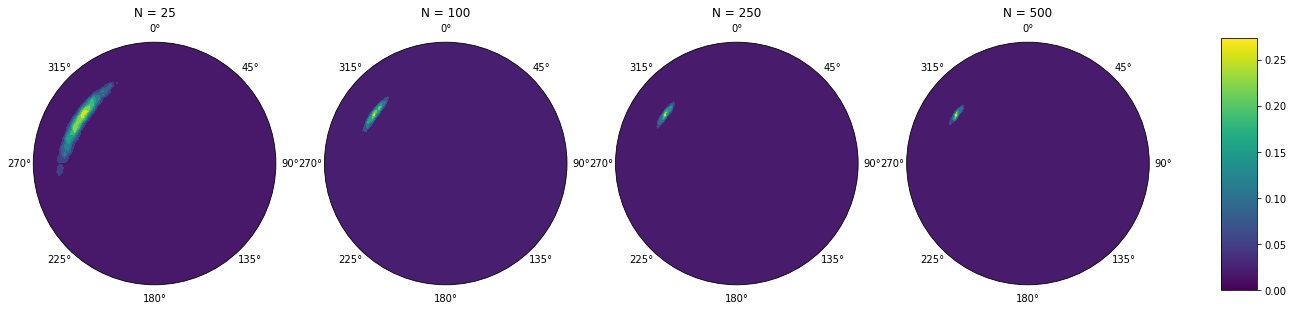

In [16]:
plotGrids(titles,grid,out)
plt.show()

### Test on some real data!

Outcrop normal direction = 18.60->348.00
Pole ~ 65->097
Sampled 1000 points in 804404688 iterations. On average 804404.0 iterations were needed per sample.


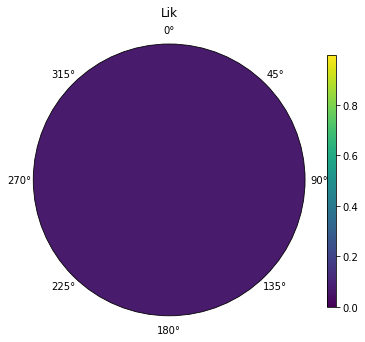

In [17]:
##TRACE 1 - WELL DEFINED ORIENTATION
x = [660.255005,660.255005,660.262024,660.348999,660.431030,660.487976,660.554016,660.632019,660.700989,660.754028,660.844971,660.909973,661.008972,661.106995,661.197021,661.244995,661.348022,661.424988,661.523987,661.614014,661.700012,661.789978,661.893005,661.893005,661.893005,661.971008,662.070007,662.168030,662.270996,662.353027,662.439026,662.528992,662.614990,662.671997,662.762024,662.859985,662.924988,662.994995,663.093018,663.182983,663.268005,663.336975,663.427002,663.520996,663.585999,663.651001,663.708008,663.784973,663.854004,663.953003,664.046997,664.120972,664.219971,664.310974,664.409973,664.508972,664.590027,664.638977,664.729004,664.729004,664.729004,664.822998,664.875977,664.929016,665.026978,665.083984,665.179016,665.276978,665.370972,665.465027,665.567993,665.666016,665.765015,665.854980,665.932983,666.007019,666.088989,666.174988,666.260986,666.351013,666.421021,666.510986,666.580017,666.666016,666.752014,666.825012,666.903015,666.976990,667.054993,667.153015,667.239014,667.312012,667.369019,667.442017,667.536011,667.638977,667.711975,667.815002,667.896973,667.958008,668.052002,668.130005,668.130005,668.130005,668.169983,668.231018,668.309021,668.382019,668.465027,668.546997,668.632996,668.731995,668.830017,668.921021,669.020020,669.104980,669.195984,669.260986,669.351013,669.432007,669.526001,669.616028,669.705994,669.804016,669.906982,669.987976,670.070007,670.169006,670.263000,670.366028,670.455994,670.455994,670.455994,670.526001,670.620972,670.715027,670.783997,670.874023,670.973022,671.046021,671.145020,671.210022,671.270996,671.361023,671.429993,671.525024,671.611023,671.684021,671.757996,671.851990,671.950012,672.012024,672.101990,672.171021,672.270020,672.343018,672.445984,672.536011,672.630005,672.729004,672.810974,672.905029,672.994995,673.085022,673.174988,673.276978,673.380005,673.469971,673.469971,673.469971,673.513977,673.546021,673.565979,673.614014,673.695007,673.747009,673.794983,673.848022,673.921021,674.002014,674.067017,674.148010,674.234009,674.289978,674.346985,674.416016,674.473022,674.559021,674.632996,674.705994,674.705994,674.705994,674.776001,674.840027,674.918030,674.994995,675.075989,675.161987,675.205994,675.291016,675.364014,675.453979,675.536011,675.625000,675.728027,675.783997,675.848999,675.931030,675.982971,676.044006,676.117004,676.182007,676.189026,676.257996,676.302002,676.357971,676.398010,676.463013,676.549011,676.549011,676.549011,676.643005,676.708008,676.773010,676.870972,676.935974,677.030029,677.106995,677.151001,677.232971,677.309998,677.390991,677.460022,677.525024,677.581970,677.630005,677.716003,677.776001,677.848999,677.927002,677.982971,678.036011,678.104980,678.174011,678.237976,678.307007,678.380005,678.469971,678.526978,678.599976,678.698975,678.783997,678.812988,678.812988,678.812988,678.911011,678.997009,679.065979,679.130005,679.198975,679.239014,679.270996,679.322998,679.383972,679.448975,679.530029,679.604004,679.681030,679.745972,679.822998,679.895996,679.981995,680.062988,680.153015,680.221985,680.270020,680.302002,680.349976,680.403015,680.455017,680.499023,680.534973,680.598999,680.598999,680.598999,680.668030,680.716980,680.776978,680.830017,680.882019,680.942993,681.010986,681.096985,681.179016,681.268005,681.328979,681.414978,681.484009,681.570007,681.651978,681.754028,681.848022,681.913025,681.978027,682.039978,682.125000,682.210999,682.296021,682.390015,682.476013,682.557983,682.648010,682.737976,682.823975,682.823975,682.823975,682.918030,682.974976,683.060974,683.143005,683.208008,683.281006,683.359009,683.440002,683.521973,683.604004,683.669006,683.767029,683.810974,683.893005,683.979004,684.072998,684.145996,684.239990,684.314026,684.387024,684.435974,684.500977,684.573975,684.638977,684.638977,684.638977,684.708008,684.789001,684.879028,684.978027,685.039001,685.119995,685.193970,685.278992,685.335999,685.434021,685.479004,685.577026,685.645996,685.728027,685.825989,685.919983,686.018005,686.088013,686.182007,686.263000,686.348999,686.398010,686.398010,686.398010,686.447021,686.531982,686.617981,686.700012,686.784973,686.859009,686.943970,687.033997,687.116028,687.197021,687.262024,687.318970,687.372009,687.440979,687.440979,687.440979,687.518005,687.549988,687.598022,687.638000,687.697998,687.758972,687.799011,687.883972,687.948975,688.026001,688.036987,688.059998,688.112976,688.112976,688.112976,688.107971,688.143005,688.187012,688.236023,688.276001,688.312012,688.380005,688.469971,688.543030,688.637024,688.718994,688.804993,688.804993,688.804993,688.882019,688.947021,689.015991,689.064026,689.137024,689.213989,689.291992,689.340027,689.393005,689.453003,689.534973,689.534973,689.534973,689.575012,689.664978,689.721008,689.721008,689.721008,689.760986]    
y = [814.494019,814.494019,814.559021,814.531006,814.489014,814.476013,814.487976,814.474976,814.500000,814.494019,814.479004,814.489990,814.479004,814.507996,814.533020,814.578003,814.599976,814.648987,814.679016,814.684021,814.695984,814.679993,814.661011,814.661011,814.661011,814.669006,814.656982,814.666016,814.666016,814.666016,814.679016,814.682983,814.674988,814.703003,814.728027,814.737000,814.768982,814.793030,814.822998,814.869019,814.922974,814.968018,815.013977,815.052002,815.104980,815.158020,815.206970,815.257019,815.281006,815.289978,815.286011,815.281006,815.250000,815.234985,815.203003,815.192017,815.211975,815.255981,815.281006,815.281006,815.281006,815.297974,815.314026,815.330017,815.338013,815.366028,815.362976,815.392029,815.409973,815.427002,815.447998,815.456970,815.445984,815.450989,815.437988,815.432983,815.434021,815.445984,815.458984,815.463989,815.489014,815.513000,815.536987,815.549988,815.562012,815.578003,815.585999,815.601990,815.612000,815.620972,815.655029,815.690979,815.739990,815.776978,815.814026,815.835999,815.853027,815.854004,815.874023,815.893982,815.911011,815.940002,815.940002,815.940002,815.979004,815.999023,816.007019,816.002991,815.981995,815.981995,815.953003,815.942017,815.950012,815.955017,815.922974,815.956970,815.961975,815.994995,816.039978,816.080994,816.119995,816.166016,816.213013,816.242981,816.244995,816.307007,816.348999,816.359009,816.375977,816.377014,816.362000,816.362000,816.362000,816.385986,816.362976,816.380981,816.405029,816.408997,816.418030,816.434021,816.442993,816.476013,816.517029,816.541992,816.565979,816.562012,816.573975,816.591003,816.606995,816.622986,816.612000,816.630981,816.635986,816.659973,816.648987,816.664978,816.664978,816.669983,816.687012,816.695984,816.695984,816.713013,816.737976,816.783997,816.809998,816.830994,816.853027,816.836975,816.836975,816.836975,816.911011,816.987976,817.070007,817.135010,817.197021,817.275024,817.361023,817.439026,817.497009,817.559021,817.632996,817.695007,817.749023,817.818970,817.888977,817.934021,817.960999,817.932983,817.948975,817.966980,817.966980,817.966980,818.012024,818.085999,818.156982,818.228027,818.289978,818.344971,818.418030,818.471985,818.530029,818.575989,818.638977,818.684998,818.706970,818.776978,818.851013,818.914001,818.992004,819.052979,819.112000,819.187012,819.250977,819.317993,819.390991,819.460999,819.541992,819.594971,819.629028,819.629028,819.629028,819.666992,819.741028,819.794983,819.825012,819.877991,819.916016,819.965027,820.039001,820.101990,820.171997,820.234009,820.301025,820.375977,820.447998,820.533997,820.588989,820.671997,820.729004,820.778992,820.848999,820.906006,820.950989,821.018005,821.093018,821.158997,821.216003,821.262024,821.310974,821.348999,821.379028,821.411987,821.434998,821.434998,821.434998,821.466003,821.520020,821.565002,821.617981,821.684021,821.765015,821.843018,821.921021,821.984009,822.057983,822.120972,822.179016,822.229004,822.304016,822.375000,822.432983,822.487000,822.528992,822.575012,822.640991,822.728027,822.783997,822.870972,822.948975,823.026978,823.122009,823.213013,823.286987,823.286987,823.286987,823.354004,823.398010,823.481018,823.559021,823.637024,823.719971,823.786011,823.840027,823.880981,823.927979,823.968018,824.023010,824.088989,824.122009,824.122009,824.143005,824.181030,824.192993,824.224976,824.245972,824.299988,824.354004,824.387024,824.424011,824.458984,824.500000,824.546021,824.572021,824.585022,824.585022,824.585022,824.601013,824.609009,824.620972,824.620972,824.655029,824.711975,824.762024,824.802979,824.843994,824.864990,824.896973,824.926025,824.958008,825.000000,825.033020,825.049988,825.067017,825.104980,825.142029,825.179016,825.223022,825.276978,825.333984,825.367004,825.367004,825.367004,825.411987,825.453003,825.478027,825.487000,825.507019,825.547974,825.606018,825.661011,825.708984,825.739990,825.771973,825.801025,825.825012,825.846008,825.875977,825.913025,825.942993,825.987976,826.026978,826.070007,826.125000,826.148010,826.148010,826.148010,826.171997,826.226990,826.281982,826.323975,826.356995,826.393982,826.447998,826.494995,826.536011,826.577026,826.630005,826.679016,826.716003,826.760986,826.760986,826.760986,826.831970,826.909973,826.995972,827.077026,827.159973,827.242004,827.302979,827.356995,827.431030,827.502014,827.578979,827.672974,827.752991,827.752991,827.752991,827.841980,827.932983,828.028992,828.114990,828.197998,828.267029,828.333008,828.377991,828.414978,828.453003,828.474976,828.508972,828.508972,828.508972,828.578979,828.653015,828.718994,828.783997,828.841980,828.913025,828.984009,829.049011,829.106018,829.168030,829.229980,829.229980,829.229980,829.291992,829.338013,829.408020,829.408020,829.408020,829.468994]
z = [496.069000,496.069000,496.106995,496.153015,496.207001,496.281006,496.364014,496.410004,496.475006,496.566986,496.595001,496.669006,496.678009,496.707001,496.743988,496.809998,496.820007,496.876007,496.868011,496.895996,496.951996,496.979004,496.979004,496.979004,496.979004,497.044006,497.080994,497.118011,497.145996,497.201996,497.257996,497.312988,497.359009,497.424011,497.462006,497.498993,497.574005,497.621002,497.640015,497.660004,497.688995,497.735992,497.755005,497.765991,497.812988,497.878998,497.925995,497.963989,498.037994,498.075989,498.104004,498.177002,498.186005,498.167999,498.186005,498.167999,498.233002,498.316986,498.363007,498.363007,498.363007,498.410004,498.466003,498.540009,498.576996,498.661011,498.670013,498.699005,498.717987,498.746002,498.765015,498.794006,498.785004,498.830994,498.885986,498.959991,499.006012,499.062012,499.098999,499.100006,499.136993,499.183990,499.257996,499.313995,499.351013,499.425995,499.489990,499.554993,499.536987,499.566010,499.557007,499.622986,499.697998,499.753998,499.782990,499.792999,499.821014,499.829987,499.894989,499.959991,499.997986,500.062988,500.062988,500.062988,500.147003,500.221008,500.277008,500.341003,500.404999,500.470001,500.506989,500.533997,500.571991,500.600006,500.618011,500.618988,500.627991,500.694000,500.722992,500.778992,500.779999,500.772003,500.755005,500.756012,500.738007,500.766998,500.778015,500.751007,500.769989,500.778992,500.769989,500.769989,500.769989,500.825989,500.799011,500.817993,500.891998,500.937988,500.967010,501.031006,501.049988,501.079010,501.144012,501.182007,501.256012,501.303009,501.348999,501.404999,501.470001,501.515991,501.553009,501.627991,501.674011,501.730011,501.757996,501.822998,501.851013,501.878998,501.924988,501.953003,501.963013,502.000000,502.037994,502.066986,502.076996,502.096008,502.114990,502.143005,502.143005,502.143005,502.191010,502.256989,502.277008,502.324005,502.354004,502.401001,502.440002,502.488007,502.526001,502.554993,502.593994,502.614014,502.643005,502.671997,502.729004,502.794006,502.868988,502.914001,502.960999,502.962006,502.962006,502.962006,502.980988,503.019989,503.031006,503.050995,503.052002,503.053986,503.110992,503.131012,503.169006,503.178986,503.199005,503.200989,503.183014,503.230988,503.269012,503.270996,503.309998,503.347992,503.348999,503.351013,503.425995,503.417999,503.475006,503.532013,503.588989,503.645996,503.674011,503.674011,503.674011,503.657013,503.695007,503.705994,503.716003,503.773010,503.800995,503.848999,503.895996,503.898010,503.917999,503.946991,503.958008,503.941986,503.888000,503.890015,503.872986,503.903015,503.950012,503.970001,504.016998,504.065002,504.102997,504.122986,504.125000,504.153992,504.200989,504.212006,504.277008,504.296997,504.298004,504.335999,504.419006,504.419006,504.419006,504.402008,504.411987,504.477997,504.533997,504.572998,504.619995,504.649994,504.687988,504.690002,504.700989,504.721008,504.721985,504.751007,504.734985,504.755005,504.765015,504.776001,504.786011,504.806000,504.825989,504.837006,504.920990,504.959991,504.980011,505.019012,505.011993,505.040985,505.052002,505.052002,505.052002,505.053986,505.118988,505.148987,505.178009,505.226013,505.237000,505.266998,505.268005,505.315002,505.316010,505.372986,505.391998,505.421997,505.468994,505.523987,505.533997,505.535004,505.600006,505.674988,505.730011,505.750000,505.778992,505.834991,505.855011,505.838013,505.885010,505.877014,505.915009,505.924011,505.924011,505.924011,505.971008,506.053986,506.101013,506.165009,506.165985,506.213989,506.252014,506.308014,506.346008,506.402008,506.476013,506.505005,506.579010,506.598999,506.618011,506.656006,506.701996,506.721985,506.740997,506.796997,506.872009,506.919006,506.967010,506.994995,506.994995,506.994995,507.061005,507.108002,507.145996,507.183014,507.265991,507.286011,507.333008,507.325989,507.399994,507.382996,507.447998,507.476990,507.550995,507.597992,507.608002,507.636993,507.627991,507.684998,507.677002,507.640991,507.623993,507.699005,507.699005,507.699005,507.753998,507.773987,507.756989,507.768005,507.804993,507.842987,507.845001,507.855011,507.902008,507.931000,507.997009,508.062012,508.109009,508.165985,508.165985,508.165985,508.166992,508.187988,508.226013,508.282990,508.312988,508.342010,508.416992,508.428009,508.466003,508.467987,508.533997,508.563995,508.537994,508.537994,508.537994,508.585999,508.569000,508.562012,508.563995,508.593994,508.651001,508.688995,508.717987,508.773987,508.803009,508.785004,508.795013,508.795013,508.795013,508.816010,508.854004,508.882996,508.949005,508.987000,509.007996,508.990997,509.037994,509.095001,509.123993,509.144012,509.144012,509.144012,509.173004,509.183990,509.230988,509.230988,509.230988,509.296997]
n=5
normal = np.array([0.197,-0.927,0.319])
normal = normal / np.linalg.norm(normal)

#print trend and plunge of normal
print ("Outcrop normal direction = %.2f->%.2f" % vec2TrendPlunge(normal))

#calculate normal-estimate tensor
icov = np.linalg.inv(np.cov(np.vstack([x,y,z])))

#generate and plot estimate
print ("Pole ~ 65->097") #dip -dip direction

grid = pdf.grid(50)
out = pdf.gridPosteriorMCMC(grid, pdf.samplePosteriorMCMC(icov,n,None,1000))
stereonet = plotGrids(["Lik"],grid,[out]) #plot results

In [5]:
########################################
##TRACE 2 - Poorly defined orientation
#######################################
x = [695.818970,695.818970,695.900024,695.965027,696.013977,696.081970,696.164001,696.254028,696.302002,696.354004,696.427979,696.517029,696.594971,696.664001,696.711975,696.809998,696.895996,696.895996,696.895996,696.960999,697.059021,697.129028,697.189026,697.275024,697.330994,697.388000,697.465027,697.546021,697.619995,697.671997,697.762024,697.838989,697.862976,697.932007,697.963013,697.994995,698.044006,698.125000,698.185974,698.250000,698.327026,698.327026,698.327026,698.372009,698.456970,698.505981,698.573975,698.648010,698.708984,698.794006,698.883972,698.978027,699.043030,699.137024,699.210022,699.299988,699.390015,699.463013,699.479004,699.523010,699.591003,699.664001,699.721008,699.770020,699.848022,699.942017,700.002014,700.002014,700.002014,700.054993,700.148987,700.218018,700.267029,700.351990,700.416992,700.489990,700.559998,700.632996,700.734985,700.812988,700.911011,700.992981,701.036987,701.072021,701.120972]
y = [836.835022,836.835022,836.896973,836.971008,837.036987,837.103027,837.164978,837.210999,837.276001,837.333984,837.392029,837.437988,837.489014,837.554016,837.619995,837.648987,837.661987,837.661987,837.661987,837.715027,837.744995,837.789978,837.851990,837.906006,837.976013,838.044983,838.094971,838.135986,838.192993,838.250000,838.296021,838.346008,838.419006,838.486023,838.562988,838.640991,838.706970,838.770020,838.853027,838.927002,838.997986,838.997986,838.997986,839.051025,839.104980,839.169983,839.236023,839.293030,839.335022,839.388977,839.434998,839.471985,839.505005,839.544006,839.601990,839.648010,839.693970,839.752014,839.799988,839.872986,839.939026,839.995972,840.065979,840.091003,840.119995,840.158997,840.221008,840.221008,840.221008,840.276978,840.315979,840.361023,840.406982,840.460999,840.513977,840.570984,840.617004,840.653992,840.676025,840.703979,840.734009,840.796997,840.892029,840.982971,841.049011]
z = [517.781982,517.781982,517.791992,517.830994,517.869019,517.898010,517.927979,517.947021,518.004028,518.033020,518.052979,518.044983,518.054993,518.103027,518.159973,518.179016,518.197998,518.197998,518.197998,518.255005,518.265015,518.302979,518.349976,518.369995,518.427002,518.484009,518.513000,518.568970,518.616028,518.682007,518.702026,518.711975,518.768982,518.789001,518.828003,518.875000,518.895020,518.869019,518.890015,518.909973,518.929993,518.929993,518.929993,518.968018,518.997009,519.062988,519.109985,519.148987,519.177002,519.197021,519.226013,519.245972,519.283020,519.257019,519.304016,519.323975,519.315979,519.362976,519.447021,519.504028,519.552002,519.598999,519.656006,519.674988,519.666992,519.650024,519.697021,519.697021,519.697021,519.763000,519.763977,519.793030,519.812012,519.831970,519.888000,519.935974,519.965027,520.002991,520.021973,520.068970,520.096985,520.080017,520.072998,520.075012,520.104980]

normal = np.array([0.47,-0.76,0.45])
normal = normal / np.linalg.norm(normal)

#calculate normal-estimate tensor
icov = np.linalg.inv(np.cov(np.vstack([x,y,z])))

#generate and plot estimate
print ("Orientation ~ 69->029")
grid = pdf.grid(1000)
out = pdf.gridPosteriorMCMC(grid,pdf.samplePosteriorMCMC(icov,25,proposalWidth=0.01))
stereonet = plotGrids(["Lik"],grid,[out]) #plot results

Orientation ~ 69->029
Sampled 5000 points in -245842511 iterations. On average -49168.0 iterations were needed per sample.


NameError: name 'plotGrids' is not defined

In [22]:
phi = 97
theta = 65
alpha = 0
e1 = 1.29e-2
e2 = 1.25e-4

P = pdf.constructP(phi,theta,alpha,e1,e2)
print(P)

[[ 0.0566407  -0.1066011   0.17651564]
 [-0.1066011   0.27269909 -0.43018883]
 [ 0.17651564 -0.43018883  0.68368521]]


In [23]:
S = pdf.samplePosteriorMCMC(P,10,None,1000)

Sampled 5000 points in -351270005 iterations. On average -70254.0 iterations were needed per sample.
